# Chapter 3 - Deep Q-learning
### Deep Reinforcement Learning *in Action*

##### Listing 3.1 - creating a gridworld game

In [7]:
from Gridworld import Gridworld
game = Gridworld(size=4, mode='static')

In [8]:
# Gridworld: initial state
game.display()

array([['+', '-', ' ', 'P'],
       [' ', 'W', ' ', ' '],
       [' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [9]:
# e.g., if the player makes move down -> down -> left
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([['+', '-', ' ', ' '],
       [' ', 'W', ' ', ' '],
       [' ', ' ', 'P', ' '],
       [' ', ' ', ' ', ' ']], dtype='<U2')

In [10]:
# and current reward is:
game.reward()

-1

In [12]:
# tensor representation of object locations:
## player, goal, pit, and wall
game.board.render_np(), game.board.render_np().shape

(array([[[0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 1, 0],
         [0, 0, 0, 0]],
 
        [[1, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 1, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]],
 
        [[0, 0, 0, 0],
         [0, 1, 0, 0],
         [0, 0, 0, 0],
         [0, 0, 0, 0]]], dtype=uint8), (4, 4, 4))

# Neural network as the Q function

- Listing 3.2: Neural network Q function

In [14]:
# mapping number output from Q-learning algorithm -> GridWord's makeMove method
action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [13]:
import numpy as np
import torch
from Gridworld import Gridworld
from IPython.display import clear_output
import random
from matplotlib import pylab as plt

# layer sizes
l1 = 64   # input representation: 4x4 (grid) x4 (player, goal, pit, wall)
l2 = 150
l3 = 100
l4 = 4

# hyperparameters
gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3, l4),
)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

- Listing 3.3: Q-learning

In [15]:
# training loop
epochs = 1000
losses = [] #1: store loss values for plotting
for i in range(epochs):  #2: the main training loop; 
    game = Gridworld(size=4, mode='static') #3: new game per each epoch
    
    #4: extract the state information and add a small amount of noise
    #### State_1 ####
    ## noise injection: helps to prevent banishing gradient from ReLU layers; also prevents overfitting by suppressing the network from memorizing details
    state_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0 
    state1 = torch.from_numpy(state_).float() #5: numpy array -> pytorch tensor -> pytorch variable
    in_progress = True #6: if the game is still in progress?
    while(in_progress): #7: while the game is in progress -> plays to completion
        qval = model(state1) #8: runs the Q-network forward -> get predicted Q values for all the actions
        qval_ = qval.data.numpy()
        if (random.random() < epsilon): #9: select action by e-greedy method
            action_ = np.random.randint(0,4)  # randomly selects the action
        else:
            action_ = np.argmax(qval_)        # or select the maximum Q-value action
        
        action = action_set[action_] #10: numeric action -> Gridworld input
        game.makeMove(action) #11: takes the action
        
        #### State_2 ####
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float() #12: after the move -> gets the new state of the game
        reward = game.reward()
        with torch.no_grad():
            newQ = model(state2.reshape(1,64))
        maxQ = torch.max(newQ) #13: finds the maximum Q value predicted from the new state
        if reward == -1: #14: calculates the target Q value with future discount (gamma)
            Y = reward + (gamma * maxQ)
        else:
            Y = reward
        Y = torch.Tensor([Y]).detach()
        X = qval.squeeze()[action_] #15: updates the element corresponding to the action taken
        loss = loss_fn(X, Y) 
        print(i, loss.item())
        clear_output(wait=True)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1: #16: if reward is -1 -> the game is still in progress
            in_progress = False
    if epsilon > 0.1: #17: decreses the epsilon value each epoch
        epsilon -= (1/epochs)

999 0.027226561680436134


Text(0,0.5,'Loss')

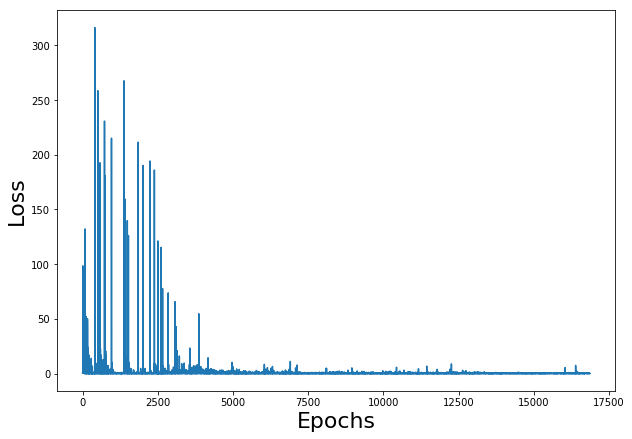

In [16]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

##### a simple linear model to compare

In [55]:
m = torch.Tensor([2.0])
m.requires_grad=True
b = torch.Tensor([1.0])
b.requires_grad=True
def linear_model(x,m,b):
    y = m@x + b
    return y

In [56]:
y = linear_model(torch.Tensor([4.]),m,b)

In [57]:
y.grad_fn

In [58]:
# y.backward()
with torch.no_grad():
    y = linear_model(torch.Tensor([4]), m, b)

In [59]:
y

tensor([9.])

In [60]:
y.grad_fn, m.grad, b.grad

(None, None, None)

- Listing 3.4: Testing the Q-network

In [33]:
def test_model(model, mode='static', display=True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print("Initial State:")
        print(test_game.display())
    in_progress = True
    while(in_progress): #1: while the game is still in progress
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_) #2: takes the action with the highest Q value
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))
        test_game.makeMove(action)
        state_ = test_game.board.render_np().reshape(1,64) + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                in_progress = None
                if display:
                    print("Game won! Reward: %s" % (reward,))
            else:
                in_progress = False
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
        i += 1
        if (i > 15):
            if display:
                print("Game lost; too many moves.")
            break
    
    win = True if in_progress is None else False
    return win

In [34]:
test_model(model, mode='static')
# test_model(model, mode='player')
# test_model(model, mode='random')

Initial State:
[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' 'P']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 1; Taking action: d
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' 'P']
 [' ' ' ' ' ' ' ']]
Move #: 2; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' 'P' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 3; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' 'P' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 4; Taking action: l
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 ['P' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 5; Taking action: u
[['+' '-' ' ' ' ']
 ['P' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Move #: 6; Taking action: u
[['+' '-' ' ' ' ']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]
Game won! Reward: 10


True

# DQN /w experience replay 

- Listing 3.5: batch updating in an online leanring scheme

In [3]:
l1 = 64
l2 = 150
l3 = 100
l4 = 4

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
from collections import deque
gamma = 0.9
epsilon = 0.3

epochs = 5000
losses = []
mem_size = 1000 #1: sents the total size of the experience replay memory
batch_size = 200 #2: mini-batch size
replay = deque(maxlen=mem_size) #3: memory replay as a deque list
max_moves = 50 #4: maximum number of moves before game is over
h = 0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        mov += 1
        qval = model(state1) #5: selects an action using the e-greedy strategy
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4) #6: computs Q values from the input state -> select action
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done) #7: creates an experience tuple of state, reward, action, and the next state
        replay.append(exp) #8: adds the experience to the experience replay list
        state1 = state2
        
        if len(replay) > batch_size: #9: if the replay list is at least as long as the mini-batch size -> begins the mini-batch training
            minibatch = random.sample(replay, batch_size) #10: randomly samples a subse of the replay list
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) #11: separates out the components of each experience into separate mini-batch tensors
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            
            Q1 = model(state1_batch) #12: recomputes Q values for the mini-batch of states to get gradients
            with torch.no_grad():
                Q2 = model(state2_batch) #13: computes Q values for the mini-batch of next states, but does not compute gradients
            
            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0]) #14: computes the target Q values we want the DQN to learn
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves: #15: if the game is over, resets status and move number
            status = 0
            mov = 0
losses = np.array(losses)

495 0.12834571301937103


In [8]:
def running_mean(x,N=50):
    c = x.shape[0] - N
    y = np.zeros(c)
    conv = np.ones(N)
    for i in range(c):
        y[i] = (x[i:i+N] @ conv)/N
    return y

Text(0,0.5,'Loss')

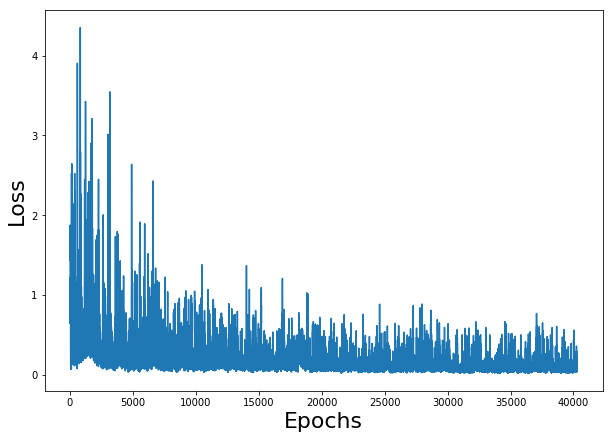

In [9]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [14]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 891
Win percentage: 89.1%


In [25]:
test_model(model, mode='random')

Initial State:
[[' ' ' ' ' ' ' ']
 [' ' ' ' '-' 'P']
 [' ' '+' ' ' 'W']
 [' ' ' ' ' ' ' ']]
Move #: 0; Taking action: l
[[' ' ' ' ' ' ' ']
 [' ' ' ' '-' ' ']
 [' ' '+' ' ' 'W']
 [' ' ' ' ' ' ' ']]
Game LOST. Reward: -10


False

###### Listing 3.7

In [83]:
import copy

l1 = 64
l2 = 150
l3 = 100
l4 = 4


model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.ReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.ReLU(),
    torch.nn.Linear(l3,l4)
)

model2 = copy.deepcopy(model) #A
model2.load_state_dict(model.state_dict()) #B

loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

gamma = 0.9
epsilon = 0.3

In [93]:
from collections import deque
epochs = 5000
losses = []
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50
h = 0
sync_freq = 500 #A
j=0
for i in range(epochs):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
    state1 = torch.from_numpy(state1_).float()
    status = 1
    mov = 0
    while(status == 1): 
        j+=1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if (random.random() < epsilon):
            action_ = np.random.randint(0,4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        state2_ = game.board.render_np().reshape(1,64) + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False
        exp =  (state1, action_, reward, state2, done)
        replay.append(exp) #H
        state1 = state2
        
        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)
            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch])
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch])
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch])
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])
            Q1 = model(state1_batch) 
            with torch.no_grad():
                Q2 = model2(state2_batch) #B
            
            Y = reward_batch + gamma * ((1-done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()
            loss = loss_fn(X, Y.detach())
            print(i, loss.item())
            clear_output(wait=True)
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()
            
            if j % sync_freq == 0: #C
                model2.load_state_dict(model.state_dict())
        if reward != -1 or mov > max_moves:
            status = 0
            mov = 0
        
losses = np.array(losses)

#A Set the update frequency for synchronizing the target model parameters to the main DQN
#B Use the target network to get the maiximum Q-value for the next state
#C Copy the main model parameters to the target network

2999 0.02813359536230564


Text(0, 0.5, 'Loss')

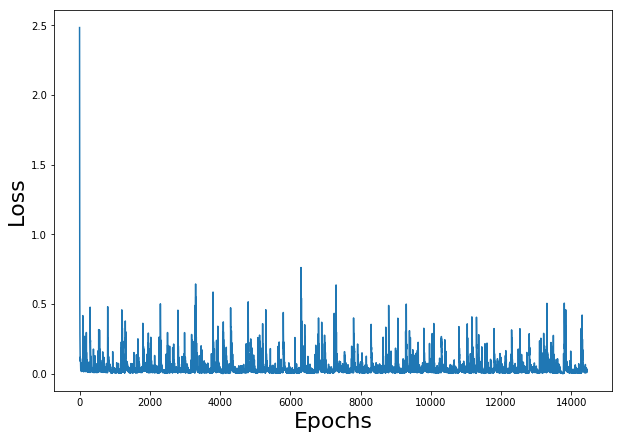

In [94]:
plt.figure(figsize=(10,7))
plt.plot(losses)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [108]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}%".format(100.0*win_perc))

Games played: 1000, # of wins: 942
Win percentage: 94.19999999999999%
